In [1]:
# Activate the local LorenzParameterEstimation package
import Pkg
Pkg.activate("../../")  # Activate the main project environment
Pkg.instantiate()  # Ensure all dependencies are installed

using DifferentialEquations
using Plots
using Random
using LinearAlgebra
using Statistics
using Enzyme

using DataFrames
using StatsPlots  # exports @df

using LorenzParameterEstimation

# Set random seed for reproducibility
Random.seed!(42)

  Activating project at `~/master_thesis/LorenzParameterEstimation`
Precompiling project...
   1939.2 ms  ✓ LorenzParameterEstimation
   6219.2 ms  ✓ LorenzParameterEstimation → LorenzVisualizationExt
  2 dependencies successfully precompiled in 11 seconds. 612 already precompiled.


TaskLocalRNG()

In [2]:
base_params = classic_params()
println("Base params: $base_params")

# Add coordinate shifts: x_s=10, y_s=0, z_s=0
shifted_params = with_coordinate_shifts(base_params, 10.0, 0.0, 0.0)
println("Shifted params: $shifted_params")

# Test parameter utilities
parameter_summary(base_params)
println()
parameter_summary(shifted_params)

Base params: L63Parameters{Float64}(10.0, 28.0, 2.6666666666666665, 0.0, 0.0, 0.0, 1.0)
Shifted params: L63Parameters{Float64}(10.0, 28.0, 2.6666666666666665, 10.0, 0.0, 0.0, 1.0)
L63Parameters Summary:
  Core parameters: σ=10.0, ρ=28.0, β=2.6666666666666665
  Coordinate shifts: None (all zero)
  Theta modification: None (θ=1)

L63Parameters Summary:
  Core parameters: σ=10.0, ρ=28.0, β=2.6666666666666665
  Coordinate shifts: x_s=10.0, y_s=0.0, z_s=0.0
  Theta modification: None (θ=1)


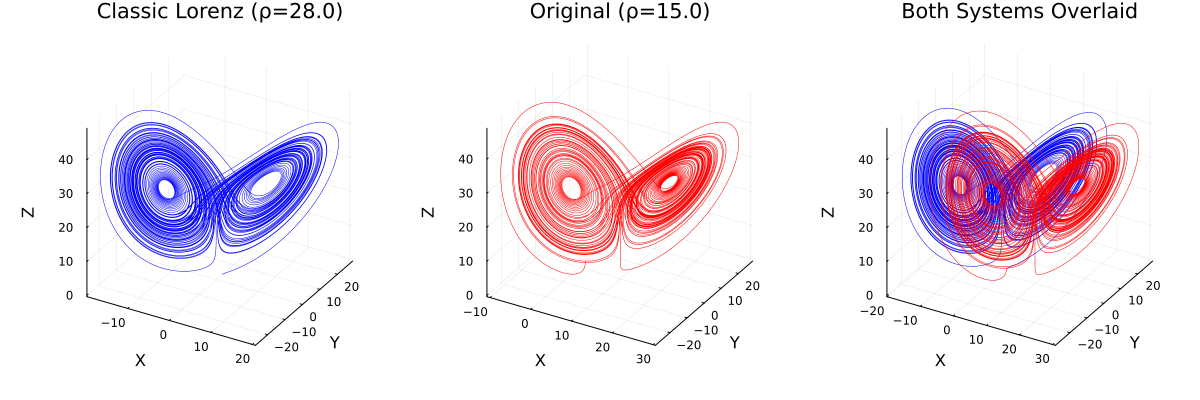

In [3]:
# Initial condition 
u0 = [1.0, 1.0, 1.0]
M  = 20_000
T  = 100.0
dt = T / M

# Integrate both systems
sol_basic  = integrate(base_params, u0, (0.0, T), dt)
sol_shifted  = integrate(shifted_params, u0, (0.0, T), dt)

# Integrate classic Lorenz system for comparison
kwargs3d = (; legend=false, linewidth=0.5, seriestype=:path3d)

p1 = plot(sol_basic.u[:, 1], sol_basic.u[:, 2], sol_basic.u[:, 3];
            title="Classic Lorenz (ρ=28.0)", xlabel="X", ylabel="Y", zlabel="Z",
            linecolor=:blue, kwargs3d...)
p2 = plot(sol_shifted.u[:, 1], sol_shifted.u[:, 2], sol_shifted.u[:, 3];
            title="Original (ρ=15.0)", xlabel="X", ylabel="Y", zlabel="Z",
            linecolor=:red, kwargs3d...)
            # Plot both trajectories overlaid
            p3 = plot(sol_basic.u[:, 1], sol_basic.u[:, 2], sol_basic.u[:, 3];
                        title="Both Systems Overlaid", xlabel="X", ylabel="Y", zlabel="Z",
                        linecolor=:blue, label="Classic Lorenz (ρ=28.0)", kwargs3d...)
            plot!(p3, sol_shifted.u[:, 1], sol_shifted.u[:, 2], sol_shifted.u[:, 3];
                        linecolor=:red, label="Shifted Lorenz (ρ=15.0)", kwargs3d...)

            plot(p1, p2, p3, layout=(1,3), size=(1200, 400))


   Optimizer: AdamW
   Data: 265 train windows, 0 val windows
   Window size: 150, stride: 75
   Updating: x_s

Epoch │   Train    │    Val     │ Parameters
──────┼────────────┼────────────┼────────────────────────────
    1 │   8.959263 │     —      │ x_s=0.168,y_s=0.000,z_s=0.000
    2 │   8.858288 │     —      │ x_s=0.332,y_s=0.000,z_s=0.000
    3 │   8.756885 │     —      │ x_s=0.495,y_s=0.000,z_s=0.000
    4 │   8.655598 │     —      │ x_s=0.663,y_s=0.000,z_s=0.000
    5 │   8.551225 │     —      │ x_s=0.831,y_s=0.000,z_s=0.000
    6 │   8.446931 │     —      │ x_s=0.997,y_s=0.000,z_s=0.000
    7 │   8.342486 │     —      │ x_s=1.164,y_s=0.000,z_s=0.000
    8 │   8.238179 │     —      │ x_s=1.331,y_s=0.000,z_s=0.000
    9 │   8.130233 │     —      │ x_s=1.503,y_s=0.000,z_s=0.000
   10 │   8.023383 │     —      │ x_s=1.668,y_s=0.000,z_s=0.000
   11 │   7.945605 │     —      │ x_s=1.823,y_s=0.000,z_s=0.000
   12 │   7.861901 │     —      │ x_s=1.949,y_s=0.000,z_s=0.000
   13 │   7.7

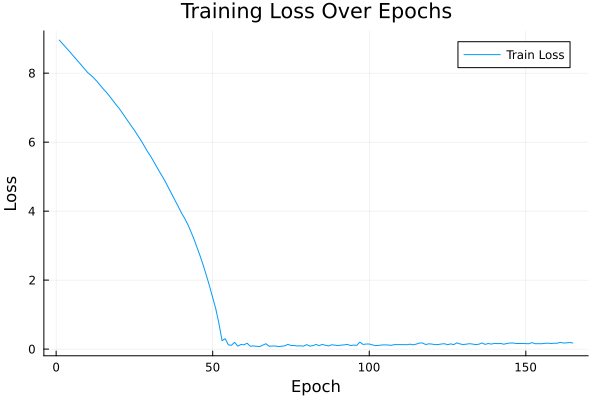

In [35]:
using LorenzParameterEstimation: TrainingMetrics

# Create metrics object for gradient tracking
coordinate_metrics = TrainingMetrics{Float64}()

# Create initial guess parameters (starting from base params)
initial_params = with_coordinate_shifts(base_params, 0.0, 0.0, 0.0)  # Start with no shifts

# Try a more aggressive optimization approach for coordinate shifts
using LorenzParameterEstimation: adamw_config

results = modular_train!(
    initial_params,                                     # Initial parameter guess
    sol_shifted;                                        # Target trajectory to fit,                  
    optimizer_config = adamw_config(learning_rate=1e-2, weight_decay=1e-4), # Higher learning rate + regularization
    loss_function = window_rmse,                        # Loss function                                         
    epochs = 1000,                                      # More epochs
    window_size = 150,                                  # Smaller windows for more frequent updates
    stride = 75,                                        # Smaller stride (50% overlap)
    batch_size = 16,                                    # Smaller batches for more frequent updates
    train_fraction = 1,                                 # Use more data for validation (30% instead of 20%)
    update_σ = false,                                   # Don't update σ parameter
    update_ρ = false,                                   # Don't update ρ parameter
    update_β = false,                                   # Don't update β parameter
    update_x_s = true,                                  # Update x_s coordinate shift
    update_y_s = false,                                 # Don't update y_s coordinate shift
    update_z_s = false,                                 # Don't update z_s coordinate shift
    verbose = true,                                     # Print training progress
    eval_every = 1,                                     # Evaluate EVERY epoch for better monitoring
    early_stopping_patience = 100,                       # More patience
    early_stopping_min_delta = 1e-9,                   # Smaller delta for more sensitive early stopping
    track_gradients = true,                             # ENABLE gradient tracking
    metrics = coordinate_metrics                        # Provide metrics object for tracking
)

# Extract results - now you can use direct field access!
best_params = results.best_params
println("Best parameters found: $best_params")
println("True x_s should be: 10.0")
println("Estimated x_s: $(best_params.x_s)")
println("Error: $(abs(best_params.x_s - 10.0))")

plot(results.train_loss, label="Train Loss", xlabel="Epoch", ylabel="Loss", title="Training Loss Over Epochs")

# Trying different window lengths

   Optimizer: AdamW
   Data: 265 train windows, 0 val windows
   Window size: 150, stride: 75
   Updating: x_s

Epoch │   Train    │    Val     │ Parameters
──────┼────────────┼────────────┼────────────────────────────
    1 │   8.959953 │     —      │ x_s=0.166,y_s=0.000,z_s=0.000
    2 │   8.860090 │     —      │ x_s=0.332,y_s=0.000,z_s=0.000
    3 │   8.758046 │     —      │ x_s=0.497,y_s=0.000,z_s=0.000
    4 │   8.652255 │     —      │ x_s=0.663,y_s=0.000,z_s=0.000
    5 │   8.550042 │     —      │ x_s=0.838,y_s=0.000,z_s=0.000
    6 │   8.442606 │     —      │ x_s=1.004,y_s=0.000,z_s=0.000
    7 │   8.339002 │     —      │ x_s=1.174,y_s=0.000,z_s=0.000
    8 │   8.233347 │     —      │ x_s=1.340,y_s=0.000,z_s=0.000
    9 │   8.126622 │     —      │ x_s=1.510,y_s=0.000,z_s=0.000
   10 │   8.020540 │     —      │ x_s=1.675,y_s=0.000,z_s=0.000
   11 │   7.934282 │     —      │ x_s=1.783,y_s=0.000,z_s=0.000
   12 │   7.902854 │     —      │ x_s=1.804,y_s=0.000,z_s=0.000
   13 │   7.8

   Optimizer: AdamW
   Data: 265 train windows, 0 val windows
   Window size: 150, stride: 75
   Updating: x_s

Epoch │   Train    │    Val     │ Parameters
──────┼────────────┼────────────┼────────────────────────────
    1 │   8.959953 │     —      │ x_s=0.166,y_s=0.000,z_s=0.000
    2 │   8.860090 │     —      │ x_s=0.332,y_s=0.000,z_s=0.000
    3 │   8.758046 │     —      │ x_s=0.497,y_s=0.000,z_s=0.000
    4 │   8.652255 │     —      │ x_s=0.663,y_s=0.000,z_s=0.000
    5 │   8.550042 │     —      │ x_s=0.838,y_s=0.000,z_s=0.000
    6 │   8.442606 │     —      │ x_s=1.004,y_s=0.000,z_s=0.000
    7 │   8.339002 │     —      │ x_s=1.174,y_s=0.000,z_s=0.000
    8 │   8.233347 │     —      │ x_s=1.340,y_s=0.000,z_s=0.000
    9 │   8.126622 │     —      │ x_s=1.510,y_s=0.000,z_s=0.000
   10 │   8.020540 │     —      │ x_s=1.675,y_s=0.000,z_s=0.000
   11 │   7.934282 │     —      │ x_s=1.783,y_s=0.000,z_s=0.000
   12 │   7.902854 │     —      │ x_s=1.804,y_s=0.000,z_s=0.000
   13 │   7.8

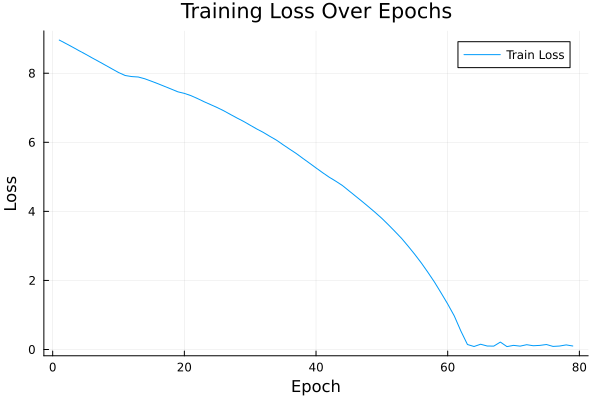

In [18]:
results_setup_1 = modular_train!(
    initial_params,                                     # Initial parameter guess
    sol_shifted;                                        # Target trajectory to fit,                  
    optimizer_config = adamw_config(learning_rate=1e-2, weight_decay=1e-4), # Higher learning rate + regularization
    loss_function = window_rmse,                        # Loss function                                         
    epochs = 1000,                                      # More epochs
    window_size = 150,                                  # Smaller windows for more frequent updates
    stride = 75,                                        # Smaller stride (50% overlap)
    batch_size = 16,                                    # Smaller batches for more frequent updates
    train_fraction = 1,                               # Use more data for validation (30% instead of 20%)
    update_σ = false,                                   # Don't update σ parameter
    update_ρ = false,                                   # Don't update ρ parameter
    update_β = false,                                   # Don't update β parameter
    update_x_s = true,                                  # Update x_s coordinate shift
    update_y_s = false,                                 # Don't update y_s coordinate shift
    update_z_s = false,                                 # Don't update z_s coordinate shift
    verbose = true,                                     # Print training progress
    eval_every = 1,                                     # Evaluate EVERY epoch for better monitoring
    early_stopping_patience = 10,                       # More patience
    early_stopping_min_delta = 1e-9,                   # Smaller delta for more sensitive early stopping
    track_gradients = true,                             # ENABLE gradient tracking
    metrics = coordinate_metrics                        # Provide metrics object for tracking
)

# Extract results - now you can use direct field access!
best_params = results_setup_1.best_params
println("Best parameters found: $best_params")
println("True x_s should be: 10.0")
println("Estimated x_s: $(best_params.x_s)")
println("Error: $(abs(best_params.x_s - 10.0))")

plot(results_setup_1.train_loss, label="Train Loss", xlabel="Epoch", ylabel="Loss", title="Training Loss Over Epochs")